In [2]:
!pip install rouge -qq

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import io
import json
import requests
from tqdm.notebook import tqdm
import subprocess
import time

from sentence_transformers import SentenceTransformer
from IPython.display import clear_output
from IPython.display import display, Markdown

from rouge import Rouge


In [4]:
rouge_score = Rouge()

#### Getting GPT-4o output 

In [5]:
df_gpt4o_mini_url = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt4o-mini.csv'
df_gpt4o_mini=pd.read_csv(df_gpt4o_mini_url)
df_gpt4o_mini.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [6]:
df_gpt4o_mini = df_gpt4o_mini.iloc[:300]

In [7]:
embedding_model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

You try to use a model that was created with version 3.0.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Getting llm answer

In [9]:
answer_llm = df_gpt4o_mini.iloc[0].answer_llm
print(answer_llm)

You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).


In [11]:
answer_llm_vector_sample = embedding_model.encode(answer_llm, show_progress_bar=False)
print(answer_llm_vector_sample[0])

-0.42244676


In [14]:
def compute_similarity(record, model):
    
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)

    return v_llm.dot(v_orig)

In [17]:
results_gpt4o_mini = df_gpt4o_mini.to_dict(orient='records')
results_gpt4o_mini[0]

{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

#### Getting similarity score on all records

In [19]:
similarity = []
for record in tqdm(results_gpt4o_mini):
    sim = compute_similarity(record, embedding_model)
    similarity.append(sim)

  0%|          | 0/300 [00:00<?, ?it/s]

In [20]:
df_gpt4o_mini['dot_product'] = similarity
df_gpt4o_mini['dot_product'].describe()

count    300.000000
mean      27.495996
std        6.384744
min        4.547925
25%       24.307846
50%       28.336863
75%       31.674308
max       39.476013
Name: dot_product, dtype: float64

In [28]:
def norm(v):
    
    return v / np.sqrt((v * v).sum())

In [29]:
def compute_similarity_normalized(record, model):
    
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']

    v_llm = model.encode(answer_llm, show_progress_bar=False)
    v_orig = model.encode(answer_orig, show_progress_bar=False)

    v_llm = norm(v_llm)
    v_orig = norm(v_orig)

    return v_llm.dot(v_orig)



#### Getting norm similarity score

In [30]:
similarity_normalized = []

for record in tqdm(results_gpt4o_mini):
    sim = compute_similarity_normalized(record, embedding_model)
    similarity_normalized.append(sim)

  0%|          | 0/300 [00:00<?, ?it/s]

In [32]:
df_gpt4o_mini['cosine'] = similarity_normalized
df_gpt4o_mini['cosine'].describe()

count    300.000000
mean       0.728392
std        0.157755
min        0.125357
25%        0.651273
50%        0.763761
75%        0.836235
max        0.958796
Name: cosine, dtype: float64

#### Output sample record

In [35]:
doc_id = '5170565b'
df_gpt4o_mini[df_gpt4o_mini['document'] == doc_id]

,answer_llm,answer_orig,document,question,course,dot_product,cosine
10,"Yes, all sessions are recorded, so if you miss...","Everything is recorded, so you won’t miss anyt...",5170565b,Are sessions recorded if I miss one?,machine-learning-zoomcamp,32.344719,0.777956
11,"Yes, you can ask your questions in advance if ...","Everything is recorded, so you won’t miss anyt...",5170565b,Can I ask questions in advance if I can't atte...,machine-learning-zoomcamp,31.441845,0.783566
12,"If you miss a session, don't worry! Everything...","Everything is recorded, so you won’t miss anyt...",5170565b,How will my questions be addressed if I miss a...,machine-learning-zoomcamp,36.380730,0.904688
13,"Yes, there is a way to catch up on a missed se...","Everything is recorded, so you won’t miss anyt...",5170565b,Is there a way to catch up on a missed session?,machine-learning-zoomcamp,33.340515,0.806303
14,"Yes, you can still interact with instructors a...","Everything is recorded, so you won’t miss anyt...",5170565b,Can I still interact with instructors after mi...,machine-learning-zoomcamp,30.606159,0.727596


In [40]:
scores = rouge_score.get_scores(df_gpt4o_mini[df_gpt4o_mini['document']==doc_id]['answer_llm'], 
                                  df_gpt4o_mini[df_gpt4o_mini['document']==doc_id]['answer_orig'])[0]
                                  
scores['rouge-1']['f']

0.45454544954545456

#### Compute the average between rougue rouge-1, rouge-2 and rouge-l for the same record from previous question


In [41]:
(scores['rouge-1']['f']+scores['rouge-2']['f']+scores['rouge-l']['f'])/3

0.35490034990035496

In [44]:
rouge_1 = []
rouge_2 = []
rouge_l = []
# rouge_avg = (rouge_1 + rouge_2 + rouge_l) / 3
rouge_avg = []

for i in tqdm(range(df_gpt4o_mini.shape[0])): 
    scores = rouge_score.get_scores(df_gpt4o_mini.iloc[i]['answer_llm'],
                                     df_gpt4o_mini.iloc[i]['answer_orig'])[0]
    rouge_1.append(scores['rouge-1']['f'])
    rouge_2.append(scores['rouge-2']['f'])
    rouge_l.append(scores['rouge-l']['f'])
    rouge_avg.append((scores['rouge-1']['f'] + scores['rouge-2']['f'] + scores['rouge-l']['f']) / 3)

  0%|          | 0/300 [00:00<?, ?it/s]

In [45]:
np.mean(rouge_2)

0.20696501983423318

<Axes: xlabel='dot_product', ylabel='Density'>

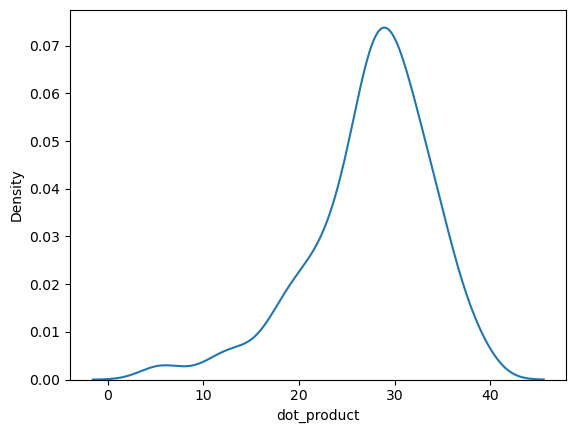

In [46]:
df_gpt4o_mini['rouge-1'] = rouge_1
df_gpt4o_mini['rouge-2'] = rouge_2
df_gpt4o_mini['rouge-l'] = rouge_l
df_gpt4o_mini['rouge_avg'] = rouge_avg

sns.kdeplot(df_gpt4o_mini['dot_product'])

<Axes: xlabel='cosine', ylabel='Density'>

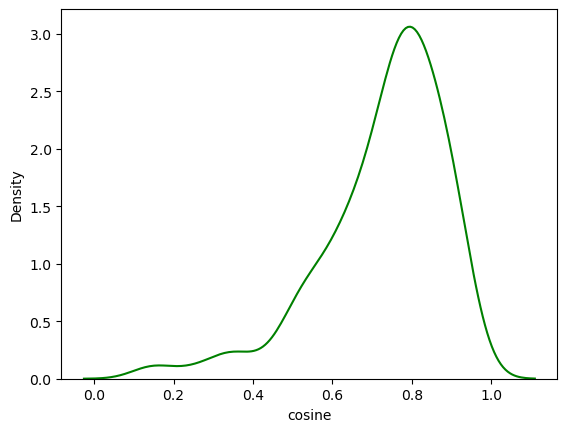

In [47]:
sns.kdeplot(df_gpt4o_mini['cosine'], color='green')

<Axes: ylabel='Frequency'>

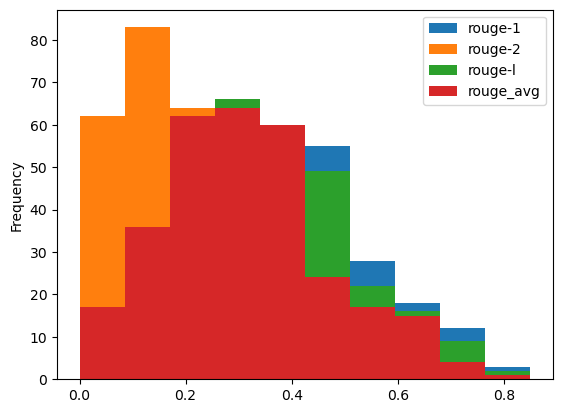

In [48]:
df_gpt4o_mini[['rouge-1', 'rouge-2', 'rouge-l', 'rouge_avg']].plot(kind='hist')

In [49]:
df_gpt4o_mini[['rouge-1', 'rouge-2', 'rouge-l', 'rouge_avg']].describe()

,rouge-1,rouge-2,rouge-l,rouge_avg
count,300.000000,300.000000,300.000000,300.000000
mean,0.378844,0.206965,0.353807,0.313205
std,0.165977,0.153550,0.162965,0.158133
min,0.000000,0.000000,0.000000,0.000000
25%,0.261625,0.097809,0.228032,0.197358
50%,0.378762,0.178671,0.337792,0.298640
75%,0.479281,0.286181,0.451613,0.404169
max,0.850000,0.739130,0.850000,0.813043
